# Project 2: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations. 

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height. 

Student tasks are in [Section 1.3](#section1pt3), [Section 2.3](#section2pt3), and [Section 3.3](#section3pt3).

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u$$
$$ \partial_t h + H \partial_x(u) = -\partial_x(h*u)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is a contant resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-x^2/w^2} $$
$$ u=0 $$
where $w=100$ km is the width of the Gaussian. We also take $H=4$ km, which is typical of the depth of the open ocean. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

In [ ]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 64 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(-L/2, L/2))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
h.change_scales(1) 
u.change_scales(1)
h['g'] = np.exp(-x**2/width**2)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + H*dx(u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        h.change_scales(1)
        h_save.append(np.copy(h['g']))
        t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

### 1.2  Plotting
The code below will make a movie of the height.
To run this, you need to have ffmpeg installed.  If you don't already have it installed, you install ffmpeg with the command: 

`conda install -c conda-forge ffmpeg`


In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))            
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)    

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value. 

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

In [ ]:
# CREATE FIGURES HERE

COMMENT ON RESULTS

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [28]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-08-01 15:35:49,747 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+01/s
2024-08-01 15:35:49,772 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-08-01 15:35:49,803 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-08-01 15:35:49,834 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-08-01 15:35:49,864 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-08-01 15:35:49,895 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-08-01 15:35:49,926 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-08-01 15:35:49,957 subsystems 0/1 INFO :: Building subproblem matric

### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-08-01 14:32:59,422 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-08-01 14:32:59,423 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/sl/8d57k6ld6_l4dm_x2rk5q_c00000gn/T/tmpvr8p7hrw/temp.m4v


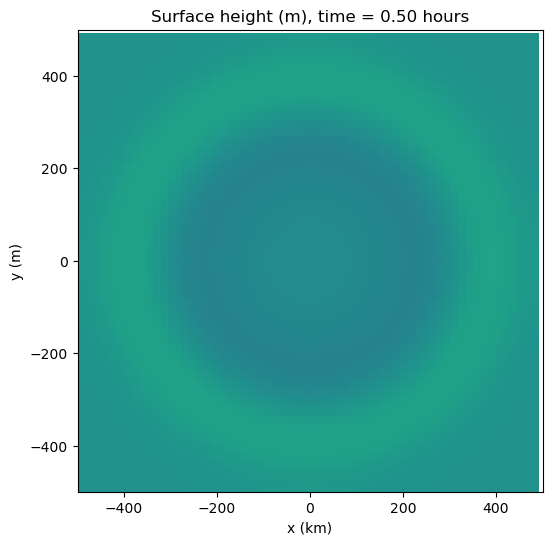

In [27]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cells below, provide an expression for the expected wave amplitude as a function of distance from the origin (x=0, y=0) and explain clearly the reasoning behind this expression. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation. 

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

In [ ]:
# ADD CODE HERE

ADD DISCUSSION HERE

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. As a reminder, the colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole.This geometry also allows us to take into account the Earth's rotation. 

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [65]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
#h.change_scales(1) # Set values on regular grid
#u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
#u['g'][0] = 0
#u['g'][1] = 0

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

2024-08-02 10:56:31,170 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 5s, Rate: 1.2e+01/s
2024-08-02 10:56:31,247 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.4e+01/s
2024-08-02 10:56:31,334 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s
2024-08-02 10:56:31,422 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.3e+01/s
2024-08-02 10:56:31,556 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s
2024-08-02 10:56:31,652 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.2e+01/s
2024-08-02 10:56:31,746 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s
2024-08-02 10:56:31,838 subsystems 0/1 INFO :: Building subproblem matri

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-08-02 10:59:04,656 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-08-02 10:59:04,658 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/sl/8d57k6ld6_l4dm_x2rk5q_c00000gn/T/tmpf8iqpats/temp.m4v


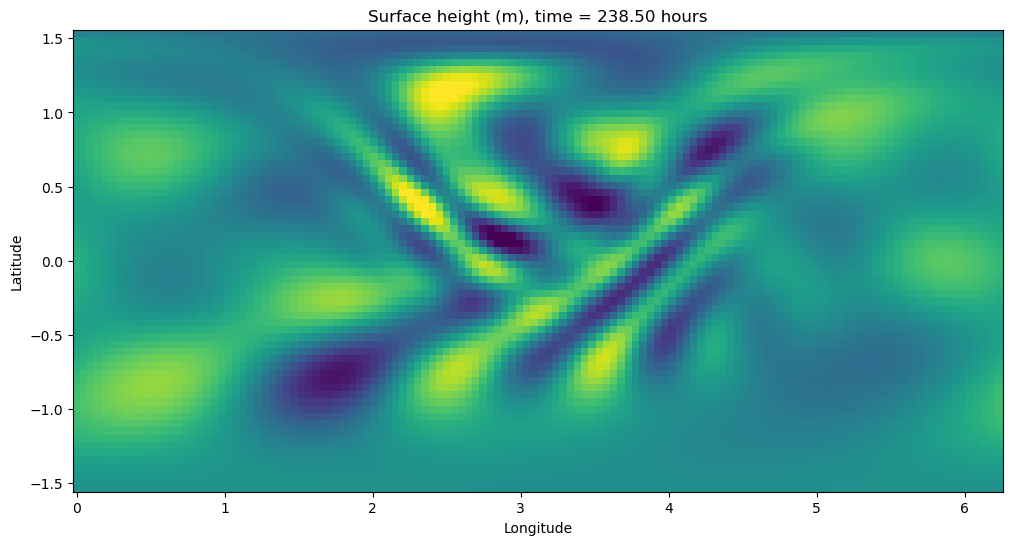

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Explain the physical mechanisms that cause the shape of the wave to vary.

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) * h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.



2024-08-02 11:00:16,250 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 5s, Rate: 1.3e+01/s
2024-08-02 11:00:16,326 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 4.5e+01/s
2024-08-02 11:00:16,416 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s
2024-08-02 11:00:16,505 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.3e+01/s
2024-08-02 11:00:16,595 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.6e+01/s
2024-08-02 11:00:16,685 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.8e+01/s
2024-08-02 11:00:16,774 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 7.0e+01/s
2024-08-02 11:00:16,865 subsystems 0/1 INFO :: Building subproblem matri

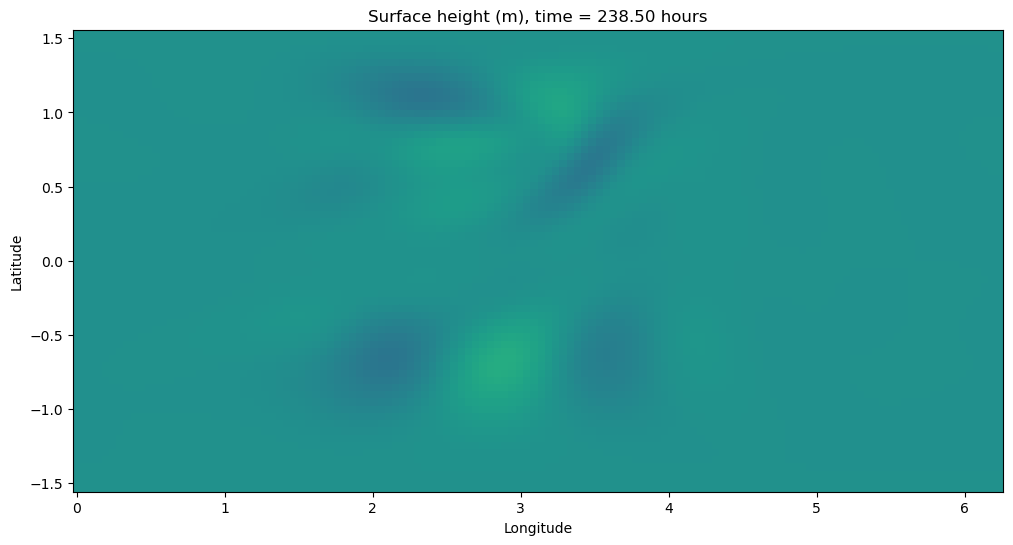

In [67]:
# Code to solve the shallow water equations in spherical geometry with damping:

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
#h.change_scales(1) # Set values on regular grid
#u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
#u['g'][0] = 0
#u['g'][1] = 0

# Sponge forcing
# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=basis)
f_x['g'] = (1/(0.1*day)) * ((1 + np.tanh((phi - 3*np.pi/2)/(np.pi/10)))/2 
                         +(1 - np.tanh((phi - np.pi/2)/(np.pi/10)))/2)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - f_x * h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta), np.squeeze(phi))  

# Define an animation function
def drawframe(n):
    plt.clf()
    #height = plt.pcolor(h_save[n,:,:], vmin=-1, vmax=1)
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)

    # Specify the axis limits and labels
    #plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    #plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())